## 4.4 Comparison against Fine-tuning with Gold Labels (Baseline)

### 4.4.1 Load Packages

In [1]:
import os

os.environ["HF_HOME"] = "/home/shared/.cache/huggingface"
os.environ["HUGGINGFACE_HUB_CACHE"] = "/home/shared/.cache/huggingface/hub"

In [2]:
import json
import torch
import torch.nn.functional as F
from dotenv import load_dotenv
from datasets import Dataset
from torch.optim import AdamW
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    default_data_collator
)
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import pickle

In [3]:
# Check GPU availability
device = "cuda" if torch.cuda.is_available() else "cpu"
print(torch.cuda.is_available())

True


In [4]:
from huggingface_hub import login
from dotenv import load_dotenv

load_dotenv()
hf_token = os.getenv("hf_token")
login(token=hf_token)

### 4.4.2 Load Student Model

In [5]:
# ✅ Step 2: Load PubMedBERT tokenizer and model with manual BERT specification

from transformers import BertTokenizer, BertForSequenceClassification, BertConfig

# student_model_id = "michiyasunaga/BioLinkBERT-base"
student_model_id = "microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext"

config = BertConfig.from_pretrained(student_model_id)
config.num_labels = 3
config.model_type = "bert" 

student_tokenizer = BertTokenizer.from_pretrained(student_model_id)
student_model = BertForSequenceClassification.from_pretrained(student_model_id, config=config)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 4.4.3 Prepare Data

In [6]:
# ✅ 0: Load soft labels from file
with open("soft_labels_from_finetuned_biogpt.json", "r") as f:
    soft_dataset = json.load(f)

In [7]:
# ✅ 1. Create a Dataset only with gold_index (teacher soft labels excluded)

# Only keep input_text and gold_index from the original soft_dataset 
pure_gold_dataset = [{"input_text": item["input_text"], "gold_index": item["gold_index"]} for item in soft_dataset]

# Convert to HuggingFace Dataset
hf_dataset_gold = Dataset.from_list(pure_gold_dataset)

In [8]:
# ✅ 2. Tokenize (soft labels excluded)
def tokenize_gold(example):
    tokens = student_tokenizer(
        example["input_text"],
        padding="max_length",
        truncation=True,
        max_length=512
    )
    tokens["gold_index"] = example["gold_index"]
    tokens["input_length"] = len(student_tokenizer.tokenize(example["input_text"]))
    return tokens

tokenized_dataset_gold = hf_dataset_gold.map(tokenize_gold, remove_columns=["input_text"])

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [9]:
# Drop examples with input length greater than 512
tokenized_dataset_gold = tokenized_dataset_gold.filter(lambda example: example["input_length"] <= 512)

Filter:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [10]:
tokenized_dataset_gold.shape

(974, 5)

In [11]:
# ✅ 3. Train Validation Split 
from sklearn.model_selection import train_test_split

tokenized_list = tokenized_dataset_gold.to_list()
train_list, val_list = train_test_split(tokenized_list, test_size=0.5, random_state=401)

train_dataset = Dataset.from_list(train_list)
val_dataset = Dataset.from_list(val_list)

In [12]:
# ✅ 4. Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=default_data_collator)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=default_data_collator)

### 4.4.4 Define Metrics

In [13]:
# ✅ 5. Define Metrics (Only CrossEntropy Loss)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
student_model.to(device)

optimizer = AdamW(student_model.parameters(), lr=1e-5)
loss_fn_ce = torch.nn.CrossEntropyLoss()

In [14]:
train_losses = []
val_losses = []
val_accuracies = []
val_precisions = []
val_recalls = []
val_f1_scores = []

epochs = 50
best_val_loss = 100
best_accuracy = 0
patience = 50
counter = 0

In [ ]:
# Reload previous metrics if they exist
with open("/home/shared/models/student_distilled_metrics/baseline_metrics.pkl", "rb") as f:
    metrics = pickle.load(f)

train_losses = metrics["train_losses"]
val_losses = metrics["val_losses"]
val_accuracies = metrics["val_accuracies"]
val_precisions = metrics["val_precisions"]
val_recalls = metrics["val_recalls"]
val_f1_scores = metrics["val_f1_scores"]
best_val_loss = metrics["best_val_loss"]       # load best loss
best_accuracy = metrics["best_accuracy"]       # load best acc

print(f"📊 Resumed training history. Best val loss: {best_val_loss:.4f}, Best accuracy: {best_accuracy:.4f}")
epoch = len(val_losses)

### 4.4.5 Training Loop

In [15]:
# ✅ Step 6: Gold-only training loop

for epoch in range(epochs):
    student_model.train()
    train_loss = 0
    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        hard_labels = batch["gold_index"].to(device)

        outputs = student_model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = loss_fn_ce(logits, hard_labels)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation loop
    student_model.eval()
    val_loss = 0
    correct = 0
    total = 0
    all_predictions = []
    all_hard_labels = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            hard_labels = batch["gold_index"].to(device)

            logits = student_model(input_ids=input_ids, attention_mask=attention_mask).logits
            loss = loss_fn_ce(logits, hard_labels)
            val_loss += loss.item()

            predictions = torch.argmax(logits, dim=1)

            correct += (predictions == hard_labels).sum().item()
            total += hard_labels.size(0)
            all_predictions.extend(predictions.cpu().numpy())
            all_hard_labels.extend(hard_labels.cpu().numpy())

    sum_0 = np.sum(np.array(all_predictions) == 0)
    sum_1 = np.sum(np.array(all_predictions) == 1)
    sum_2 = np.sum(np.array(all_predictions) == 2)
    print(f"Predictions: {sum_0}x0s, {sum_1}x1s, {sum_2}x2s")

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    accuracy = correct / total
    val_accuracies.append(accuracy)

    precision = precision_score(all_hard_labels, all_predictions, average="weighted", zero_division=0)
    recall = recall_score(all_hard_labels, all_predictions, average="weighted", zero_division=0)
    f1 = f1_score(all_hard_labels, all_predictions, average="weighted", zero_division=0)

    val_precisions.append(precision)
    val_recalls.append(recall)
    val_f1_scores.append(f1)

    print(f"Epoch {epoch + 1} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, "
          f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

    # Early Stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0
        if accuracy >= best_accuracy:
            best_accuracy = accuracy
            # Save the best gold-only model
            #output_dir = "/home/shared/models/student_goldfinetune"
            #student_model.save_pretrained(output_dir)
            #student_tokenizer.save_pretrained(output_dir)
            #print("Best model saved! (Gold-only)")
            print("New best val_loss:", best_val_loss, "New best accuracy:", best_accuracy)
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered")
            break

Predictions: 6x0s, 0x1s, 481x2s
Epoch 1 - Train Loss: 0.9822, Val Loss: 0.9186, Accuracy: 0.5606, Precision: 0.4299, Recall: 0.5606, F1-Score: 0.4118
New best val_loss: 0.9185720951326432 New best accuracy: 0.5605749486652978
Predictions: 0x0s, 0x1s, 487x2s
Epoch 2 - Train Loss: 0.9559, Val Loss: 0.9096, Accuracy: 0.5626, Precision: 0.3166, Recall: 0.5626, F1-Score: 0.4052
New best val_loss: 0.909616356895816 New best accuracy: 0.5626283367556468
Predictions: 30x0s, 0x1s, 457x2s
Epoch 3 - Train Loss: 0.9274, Val Loss: 0.8655, Accuracy: 0.6016, Precision: 0.6022, Recall: 0.6016, F1-Score: 0.4975
New best val_loss: 0.86549973487854 New best accuracy: 0.6016427104722792
Predictions: 174x0s, 0x1s, 313x2s
Epoch 4 - Train Loss: 0.8361, Val Loss: 0.8302, Accuracy: 0.6530, Precision: 0.5869, Recall: 0.6530, F1-Score: 0.6179
New best val_loss: 0.8302073324880292 New best accuracy: 0.6529774127310062
Predictions: 151x0s, 0x1s, 336x2s
Epoch 5 - Train Loss: 0.7496, Val Loss: 0.8215, Accuracy: 0.66

In [17]:
# Save training metrics
metrics = {
    "train_losses": train_losses,
    "val_losses": val_losses,
    "val_accuracies": val_accuracies,
    "val_precisions": val_precisions,
    "val_recalls": val_recalls,
    "val_f1_scores": val_f1_scores,
    "best_val_loss": best_val_loss,
    "best_accuracy": best_accuracy,
}

with open("/home/shared/models/student_distilled_metrics/baseline_metrics.pkl", "wb") as f:
    pickle.dump(metrics, f)

print("✅ Training metrics saved.")

✅ Training metrics saved.


In [18]:
import matplotlib.pyplot as plt

In [19]:
epochs = list(range(1, len(val_losses) + 1))  # Epoch numbers

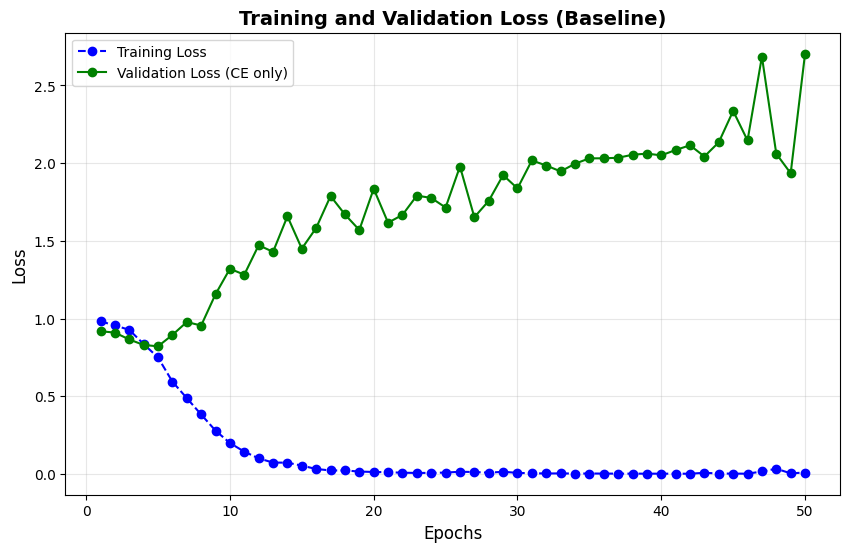

In [24]:
# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label="Training Loss", marker="o", linestyle="--", color="blue")
plt.plot(epochs, val_losses, label="Validation Loss (CE only)", marker="o", linestyle="-", color="green")
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Training and Validation Loss (Baseline)", fontsize=14, fontweight="bold")
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.show()

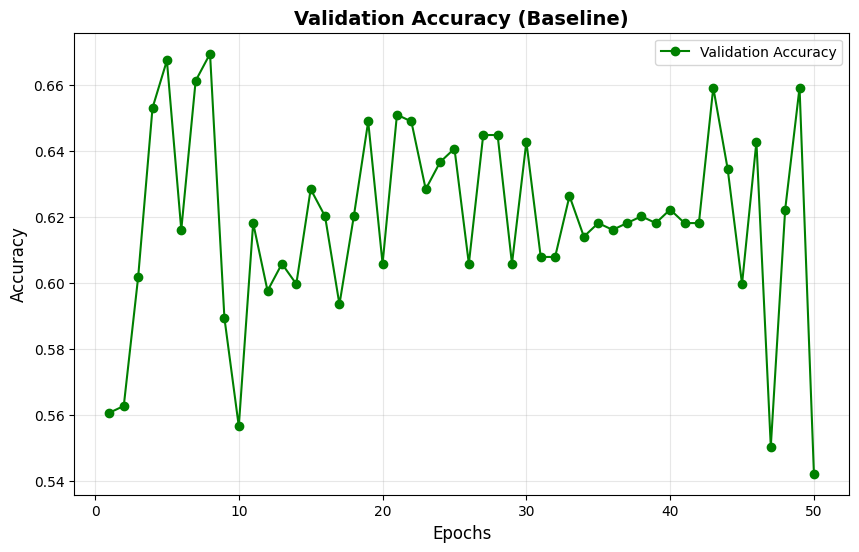

In [26]:
# Plot Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, val_accuracies, label="Validation Accuracy", marker="o", linestyle="-", color="green")
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Validation Accuracy (Baseline)", fontsize=14, fontweight="bold")
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.show()

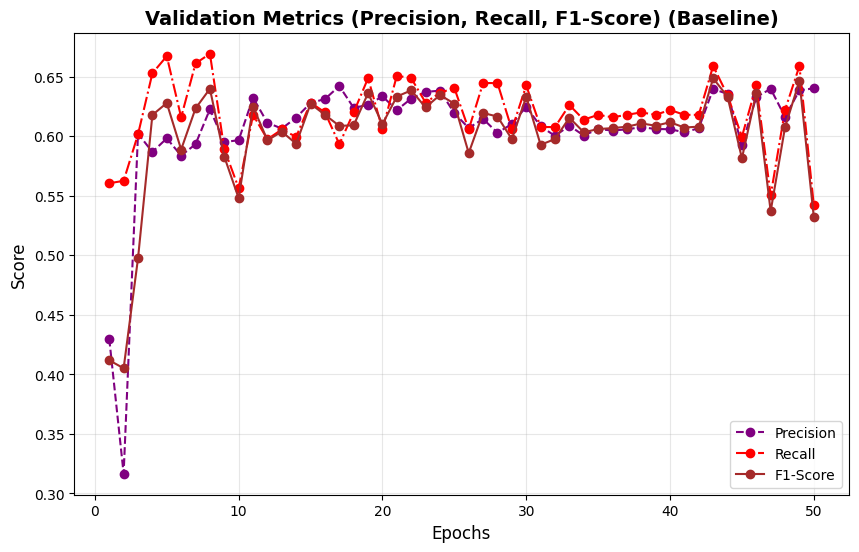

In [27]:
# Plot Precision, Recall, and F1-Score
plt.figure(figsize=(10, 6))
plt.plot(epochs, val_precisions, label="Precision", marker="o", linestyle="--", color="purple")
plt.plot(epochs, val_recalls, label="Recall", marker="o", linestyle="-.", color="red")
plt.plot(epochs, val_f1_scores, label="F1-Score", marker="o", linestyle="-", color="brown")
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.title("Validation Metrics (Precision, Recall, F1-Score) (Baseline)", fontsize=14, fontweight="bold")
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.show()